<h1 class="header"><img class="logo" src="../images/socib_logo.png" width="200px"></h1>

<h3> STYLING NOTEBOOK (OPTIONAL)</h3>

In [5]:
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('https://github.com/socib/API_examples/SOCIB_API/master/style/custom/custom.css').read())

<h3>HANDY PYTHON PACKAGES</h3>

In [6]:
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from json2html import *
from IPython.display import HTML
%matplotlib inline

<h3>PREREQUISITES</h3>

In [7]:
api_key = '' #write you SOCIB api_key
api_url = 'http://api.socib.es'
headers = {
    'accept': 'application/vnd.socib+json',
    'apikey': api_key,
}

<h3> WHAT ARE EXACTLY DATA-SOURCES?</h3>

SOCIB Data-sources represents the so-called <i>deployments</i>. A deployment is an instrument&platform enssemble deployed (placed or released) to retrieve data from the ocean. During the time period this combo is active, the data measured by it is said to belong to the same deployment (same intrument&platform enssemble -> same constrains) and therefore grouped together. This way, deployments have stand-out as the basic unit of organization for oceanographic data and SOCIB archiving reflects this policy.

For example, see here the deployment of a platform (an Oceanographic buoy) with all its instruments: wave recorder, weather station, conductivity and temperature recorder, currentemeter, current profiler ...
<img src="../images/deployment_ocenographic_buoy.jpg">

<h3>WHICH ENDPOINT DO I USE TO EXPLORE SOCIB DATA-SOURCES?</h3> 

As we already saw in [Quick start](../tips/quick_start.ipynb) there is an ENDPOINT that allows users to dive into all the data-sources (deployments) that SOCIB has ever performed:

In [8]:
end_point = '/data-sources/'
request = requests.get('%s%s' % (api_url, end_point), headers=headers)
response = json.loads(request.text)

print('Requested url: '+'%s%s' % (api_url, end_point))
print('SOCIB has performed so far a total of %s deployments'%(response['count']))

Requested url: http://api.socib.es/data-sources/
SOCIB has performed so far a total of 769 deployments


<h3>HOW DOES IT WORKS?</h3> 

Regarding the data-sources, the API resembles a catalogue that someone can read-trough; with a number of pages to turn and, as content of such pages, a number of deployments:

In [9]:
print('Catalogue total number of pages: '+str((response['count']/len(response['results']))+1))

Catalogue total number of pages: 97


In [10]:
print('Number of deployments per page: '+str(len(response['results'])))

Number of deployments per page: 8


<h3>OVERVIEW OF A GIVEN DATA-SOURCE - <span> DEPLOYMENT'S METADATA </span></h3>

Imagine you are on page 10 of the data-sources catalogue:

In [11]:
end_point = '/data-sources/?page=10'
request = requests.get('%s%s' % (api_url, end_point), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s' % (api_url, end_point))
print('Next url: '+response['next'])
print('Previous url: '+response['previous'])

Requested url: http://api.socib.es/data-sources/?page=10
Next url: http://api.socib.es/data-sources/?page=11
Previous url: http://api.socib.es/data-sources/?page=9


Each data-source (stored as <b>'results'</b> in the response of the above query), is uniquely identified by 13 properties: <i>name, coverage_bounding_box, type, id, status, description, data_type, instrument, platform, update_time, initial_time, end_time & processing levels</i>.<br>
Let's have a look to the metadata of one of the data-sources:

In [12]:
targeted_deployment = response['results'][5]#i.e deployment/data-source number 5 of the above page
metadata = {k:v for k, v in targeted_deployment.items() if k != 'entries'} #skipping the deployment data for later
HTML(json2html.convert(json=metadata))

Depending on the nature of the platform composing the deployment enssemble (instrument & platfrom) a data-source can be mobile or fixed and therefore the resulting deployment's coverage will be reduced to a point (case of moorings) or to a wider polygon (case of drifters, profilers, vessels etc). <br>Let's have a look to the present one:

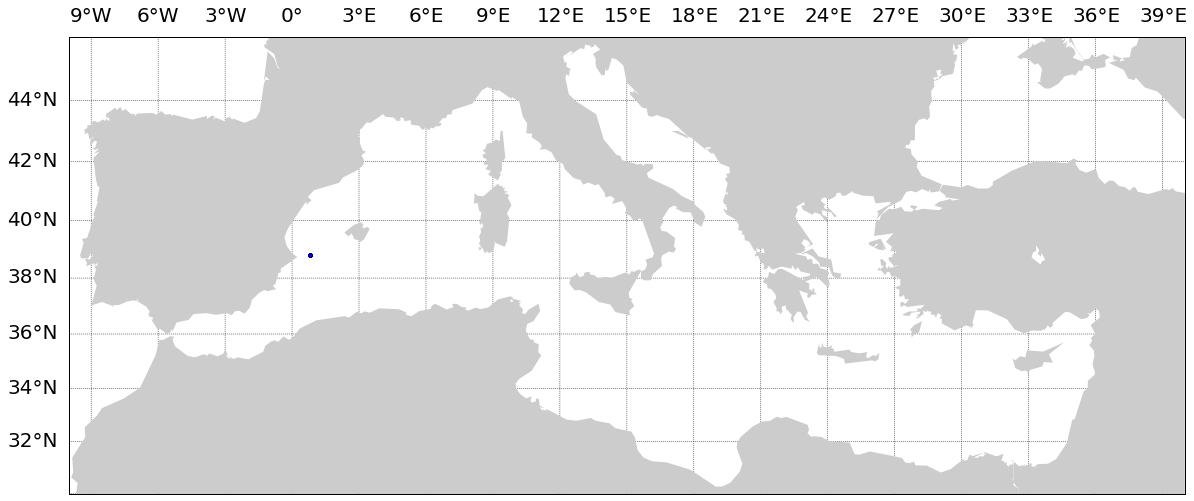

In [13]:
fig = plt.figure(figsize=(20,16))
m = Basemap(projection='merc', llcrnrlat=30., urcrnrlat=46.,llcrnrlon=-10, urcrnrlon=40., lat_ts=38., resolution='l')
m.fillcontinents(zorder=2)
m.drawparallels(np.arange(-90.,91.,2.), labels=[1,0,0,0], linewidth=0.5, zorder=1, fontsize=20)
m.drawmeridians(np.arange(-180.,181.,3.), labels=[0,0,1,0], linewidth=0.5, zorder=1, fontsize=20)
lats = [item[1] for item in targeted_deployment['coverage_bounding_box']['coordinates'][0]]
lons = [item[0] for item in targeted_deployment['coverage_bounding_box']['coordinates'][0]]
x,y = m( lons, lats )
if all(targeted_deployment['coverage_bounding_box']['coordinates'][0][0] == item for item in targeted_deployment['coverage_bounding_box']['coordinates'][0]):
    m.plot(x, y, 'bo', markersize=4)
else:
    #mobile platforms
    xy = zip(x,y)
    poly = Polygon( xy, facecolor='white', edgecolor='blue', alpha=0.4, linewidth=2,zorder=3)
    plt.gca().add_patch(poly)

On the data-source overview the variables measured by the deployment are grouped in the different processing levels:
<ul>
    <li>L0: raw data</li>
    <li>L1: data with quality flags (data classified as good, bad, potentially good etc) </li>
    <li>L2: derived product (i.e vertical profiles form gliders) </li>
</ul>
<br>
This way, when a variable is available in more than one processing level it is up to the user choosing the most suitable one regarding the work to be done (validation, assimilation etc).

<h3>DATA FROM A GIVEN DATA-SOURCE - <span> DEPLOYMENT'S NETCDFS</span></h3>

Each data-source's data is a collection of netCDFS stored as <b>'entries'</b>:

In [17]:
targeted_deployment = response['results'][0]#i.e deployment number 0 of the above page
data = {k:v for k, v in targeted_deployment.items() if k == 'entries'} #choosing just the deployment data
print('The deployment targeted produced %s netCDFs' % (len(data['entries'])))

The deployment targeted produced 38 netCDFs


Each so-called 'entry' (netCDF) is uniquely identified by a serie of properties: <i> name, last_update, initial_datetime, end_datetime, services, viewers and processing_level.</i><br>Let's explore one of the entries (netCDF) from the above data-source:

In [18]:
targeted_deployment = response['results'][5]#i.e deployment number 0 of the above page
data = {k:v for k, v in targeted_deployment.items() if k == 'entries'} #choosing just the deployment data
targeted_netCDF = 0 #i.e netCDF number 0 of the above deployment
HTML(json2html.convert(json=data['entries'][targeted_netCDF]))

As we saw before, the data measured by a deployment is grouped together in collection of netCDF files in SOCIB archiving. Due to its Open Acess policy, all netCDFs from deployments are distributed by SOCIB THREDDS data servers. These servers maps the available netCDFs and provide several services and viewers for it to be downloaded, accessed and explored. <br>See some above.

All the services implies a certain level of knowledge about the netCDF format to operate with the data. Nevertheless, SOCIB API offers auxiliary endpoints that serve the a data-source's data straightway and abstract the user from any underlying format. In next notebooks we will have a look to such auxiliary endpoints.

<h3>DETAILED VIEW OF A GIVEN DATA-SOURCE - <span> SHORCUT TO A KNOWN DEPLOYMENT </span></h3>

We have found and explored the above deployment by targeting an specific page number and position on this page, but this whole searching process can be skipped onwards by preserving its id: 

In [19]:
end_point = '/data-sources/'+targeted_deployment['id']
request = requests.get('%s%s' % (api_url, end_point), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s. Be aware of the id.' % (api_url, end_point))

Requested url: http://api.socib.es/data-sources/f83ac983ea. Be aware of the id.


In [20]:
targeted_deployment = response
metadata = {k:v for k, v in targeted_deployment.items() if k != 'entries'} #skipping the deployment data for later
HTML(json2html.convert(json=metadata))

<h3>WHAT ELSE?</h3>

<ul>
<li><b>SEARCHING FOR CERTAIN DATA-SOURCES</b><br><br>If you want to retrieve SOCIB data-sources matching certain criteria, please have a look at the [Example 2](searching_for_certain_data_sources.ipynb) ('Searching for certain data-sources'), where it is explained how to set a searching criteria over the generic /data-source/ ENDPOINT to filter the available data-sources according to your needs.</li>
<br>
<li><b>REQUESTING A DATA-SOURCE'S DATA</b> <br><br> If you want to know more about how to access a given data-source's data overlooking the netCDF format, please have a look at the [Example 3](requesting_a_data_sources_data.ipynb) ('Accessing the data of a data-source'), where it is explained how to use auxiliary endpoints to request a deployments data.</li>
<br>
<li><b>SUBSETTING A DATA-SOURCE'S DATA</b> <br><br>If you want to know more about how to subset a given data-source's data overlooking the netCDF format, please have a look at the [Example 4](subsetting_a_data_sources_data.ipynb) ('Subsetting a data-source's data'), where it is explained how to use query parameters over the API auxiliary endpoints to subset a deployments data.</li>
<br>
<li><b>RESAMPLING A DATA-SOURCE'S DATA</b> <br><br>If you want to know more about how to resample a given data-source's data overlooking the netCDF format, please have a look at the [Example 5](resampling_a_data_sources_data.ipynb) ('Resampling a data-source's data'), where it is explained how to use query parameters over the API auxiliary endpoints to resample a deployments data.</li>
</ul>